# <center><a name='temp_an'>Etude de données météorologiques: Analyse</a></center>

## <a name='temp_an_Sommaire'>1. Sommaire</a> <a href='#temp_an'>↑Haut</a>
<a href='#temp_an_Sommaire'>**1. Sommaire**</a>

<a href='#temp_an_lib_et_fonct'>**2. Librairies et fonctions**</a>

<a href='#temp_an_importation_et_prep'>**3. Importation et préparation des données**</a>

<a href='#temp_an_proj'>**4. Projection des températures**</a>
- <a href='#temp_an_df'>**4.1 Création des dataframes**</a>
- <a href='#temp_an_month'>**4.2 Projection mensuelle**</a>
- <a href='#temp_an_day'>**4.3 Projection journalière**</a>
- <a href='#temp_an_MSE'>**4.4 MSE et RMSE**</a>

<a href='#temp_an_occ'>**5. Occurence de chaleur et de froid**</a>
- <a href='#temp_an_occ_df'>**5.1 Création des dataframes**</a>
- <a href='#temp_an_chaud'>**5.2 Occurence de chaleur**</a>
  - <a href='#temp_an_chaud_clim'>**5.2.1 Par climat**</a>
  - <a href='#temp_an_chaud_nat'>**5.2.2 National**</a>
- <a href='#temp_an_froid'>**5.3 Occurence de froid**</a>
  - <a href='#temp_an_froid_clim'>**5.3.1 Par climat**</a>
  - <a href='#temp_an_froid_nat'>**5.3.2 National**</a>
  
<a href='#temp_an_polar'>**6. Graphique polaire**</a>

## <a name='temp_an_lib_et_fonct'>**2. Librairies et fonctions**</a> <a href='#temp_an'>↑Haut</a>

In [2]:
# graph
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolor

# Dataframe
import pandas as pd
import numpy as np
import datetime as dt

# prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# polar plot
from IPython.display import HTML
import matplotlib
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.lines import Line2D

# bib
from utils.climat_color import climat_color

In [3]:
meteo_data= pd.read_csv("data/meteorological_data.csv")

meteo_data.date= pd.to_datetime(meteo_data.date)

In [4]:
def graph_occurence_chaleur(df, title):
    ax1= df.plot( x='date', y="tx_20", label="tx_20", c="blue", style= "-o", figsize=(20,10))
    ax2= df.plot( x='date', y="tx_25", label="tx_25", ax= ax1, c="orange", style= "-o")
    ax3= df.plot( x='date', y="tx_30", label="tx_30", ax= ax1, c='green',  style="-o")
    ax4= df.plot( x='date', y="tn_20", label="tn_20", ax= ax1, c="purple", style="-o")

    plt.title(title)
    plt.legend()

    plt.show()

In [5]:
def graph_occurence_froid(df, title):
    ax1= df.plot( x='date', y="tn_n10", label="tn_n10", c="blue", figsize=(20,10), style="-o")
    ax2= df.plot( x='date', y="tn_n5", label="tn_n5", ax= ax1, c="orange", style="-o")
    ax3= df.plot( x='date', y="tn_0", label="tn_0", ax= ax1, c='green', style= "-o")
    ax4= df.plot( x='date', y="tx_0", label="tx_0", ax= ax1, c="purple", style= "-o")

    plt.title(title)
    plt.legend()

    plt.show()

In [6]:
def graph_forecast(df, forecast_t, forecast_c, periods):
    ax.plot(df.date.dt.year,df[forecast_t], "o", label=forecast_t, c=forecast_c)
    m= Prophet()
    m.fit(df.loc[df.date.dt.year < df.date.dt.year.max() - 2].rename(columns={"date":"ds", forecast_t: "y"}))
    future= m.make_future_dataframe(periods=periods, freq='y')
    forecast= m.predict(future)
    ax.plot( forecast.ds.dt.year, forecast.yhat)
    ax.fill_between(forecast.ds.dt.year, forecast.yhat_lower, forecast.yhat_upper, alpha=0.2, color=forecast_c)

In [7]:
def graph_forecast_period(df, forecast_t, forecast_c, periods, ax, freq):
    r,g,b = mcolor.to_rgb(forecast_c)
    new_color= b,r,g
    learning_df = df.loc[df.date.dt.year < df.date.dt.year.max() - 2]
    ax.plot(learning_df.date, learning_df[forecast_t], ".", label=forecast_t+ "_train", c=forecast_c)
    ax.plot(df.loc[df.date.dt.year >= df.date.dt.year.max() - 2].date, df.loc[df.date.dt.year >= df.date.dt.year.max() - 2][forecast_t], "*",  label=forecast_t+ "_test", c=new_color)
    # prediction
    m= Prophet()
    m.fit(learning_df.rename(columns={"date":"ds", forecast_t: "y"}))
    future= m.make_future_dataframe(periods=periods, freq=freq)
    forecast= m.predict(future)
    # forecast curve
    ax.plot( forecast.ds, forecast.yhat)
    # forecast variation
    ax.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, alpha=0.2, color=forecast_c)
    ax.legend()
    ax.set_ylabel("Température")
    ax.set_xlabel("Année")
    ax.set_title("projection de la variable " + forecast_t)
    return m

## <a name='temp_an_proj'>4. Projection des températures</a> <a href='#temp_an'>↑Haut</a>

### <a name='temp_an_df'>4.1 Création des dataframes</a> <a href='#temp_an'>↑Haut</a>

In [8]:
# Dataframe des températures journalières
day_temp_data = (meteo_data
                 .groupby(by=["id_sta", "climat", "name", pd.Grouper(key="date", freq="D")])
                 .agg(min= ('t', min),
                      mean= ("t", np.mean),
                      max= ("t", max)
                     )
                ).reset_index()
day_temp_data.head(5)

id_sta        climat       name       date   min     mean   max
0    7005  océanique NO  Abbeville 1996-01-01  2.70  3.47000  4.39
1    7005  océanique NO  Abbeville 1996-01-02  1.30  2.58375  3.80
2    7005  océanique NO  Abbeville 1996-01-03  0.39  1.38250  2.60
3    7005  océanique NO  Abbeville 1996-01-04  0.10  1.37250  2.70
4    7005  océanique NO  Abbeville 1996-01-05  1.39  2.99875  4.80

In [9]:
# Dataframe des températures mensuelle
month_temp_data = (day_temp_data
                   .groupby(by=["id_sta", "climat", "name", pd.Grouper(key="date", freq="M")])
                   .agg(min= ('min', np.mean),
                        mean= ("mean", np.mean),
                        max= ("max", np.mean)
                       )
                  ).reset_index()
month_temp_data["date"]= month_temp_data["date"].apply(lambda dt: dt.replace(day=1))
month_temp_data.head(5)

id_sta        climat       name       date       min      mean        max
0    7005  océanique NO  Abbeville 1996-01-01  1.078387  2.627137   4.607742
1    7005  océanique NO  Abbeville 1996-02-01  0.143448  2.106293   4.493793
2    7005  océanique NO  Abbeville 1996-03-01  1.711935  4.691688   8.175161
3    7005  océanique NO  Abbeville 1996-04-01  4.629000  8.899327  13.534667
4    7005  océanique NO  Abbeville 1996-05-01  6.342258  9.690703  12.901613

In [10]:
# Dataframe des températures annuelle
year_temp_data = (day_temp_data
      .groupby(by=["id_sta", "climat", "name", pd.Grouper(key="date", freq="Y")])
      .agg(min= ('min', np.mean),
           mean= ("mean", np.mean),
           max= ("max", np.mean)
          )
     ).reset_index()
year_temp_data["date"]= year_temp_data["date"].apply(lambda dt: dt.replace(day=1, month=1))
year_temp_data.head(5)

id_sta        climat       name       date       min       mean        max
0    7005  océanique NO  Abbeville 1996-01-01  5.955492   9.060242  12.416721
1    7005  océanique NO  Abbeville 1997-01-01  7.325397  10.550473  14.176959
2    7005  océanique NO  Abbeville 1998-01-01  7.683589  10.558377  13.580192
3    7005  océanique NO  Abbeville 1999-01-01  8.224219  11.184595  14.404110
4    7005  océanique NO  Abbeville 2000-01-01  8.203279  10.965067  13.904645

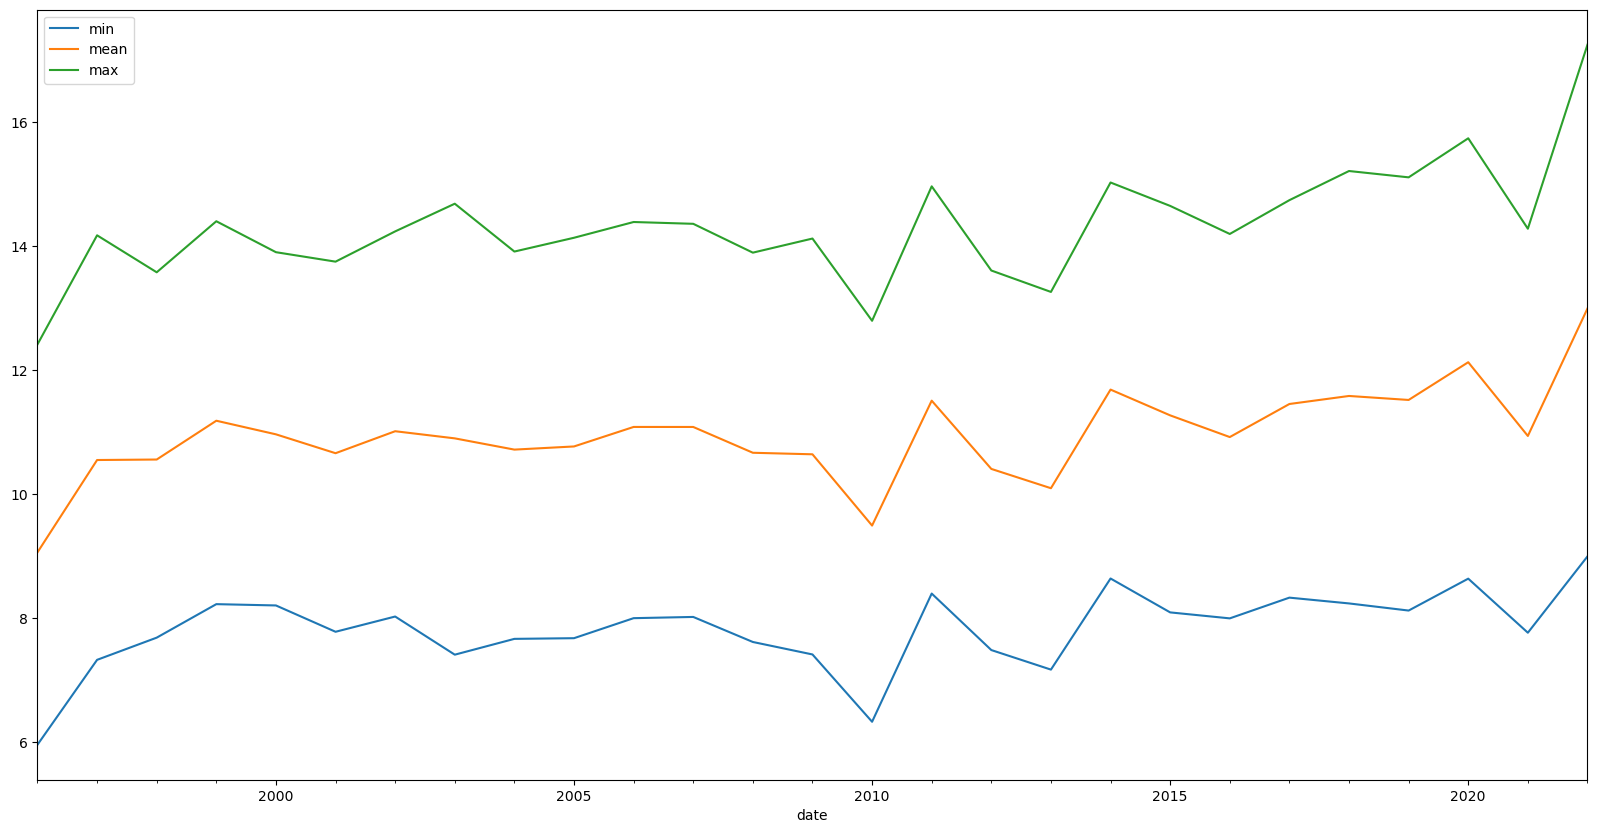

In [11]:
fig = plt.Figure(figsize=(20,10))

year_temp_data.loc[year_temp_data.name== "Abbeville"].drop(columns=["id_sta"]).plot(x="date", figsize=(20,10))
plt.show()

### <a href='#temp_an_month'>4.2 Projection mensuelle</a>

13:26:11 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing
13:26:11 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing
13:26:12 - cmdstanpy - INFO - Chain [1] start processing
13:26:12 - cmdstanpy - INFO - Chain [1] done processing


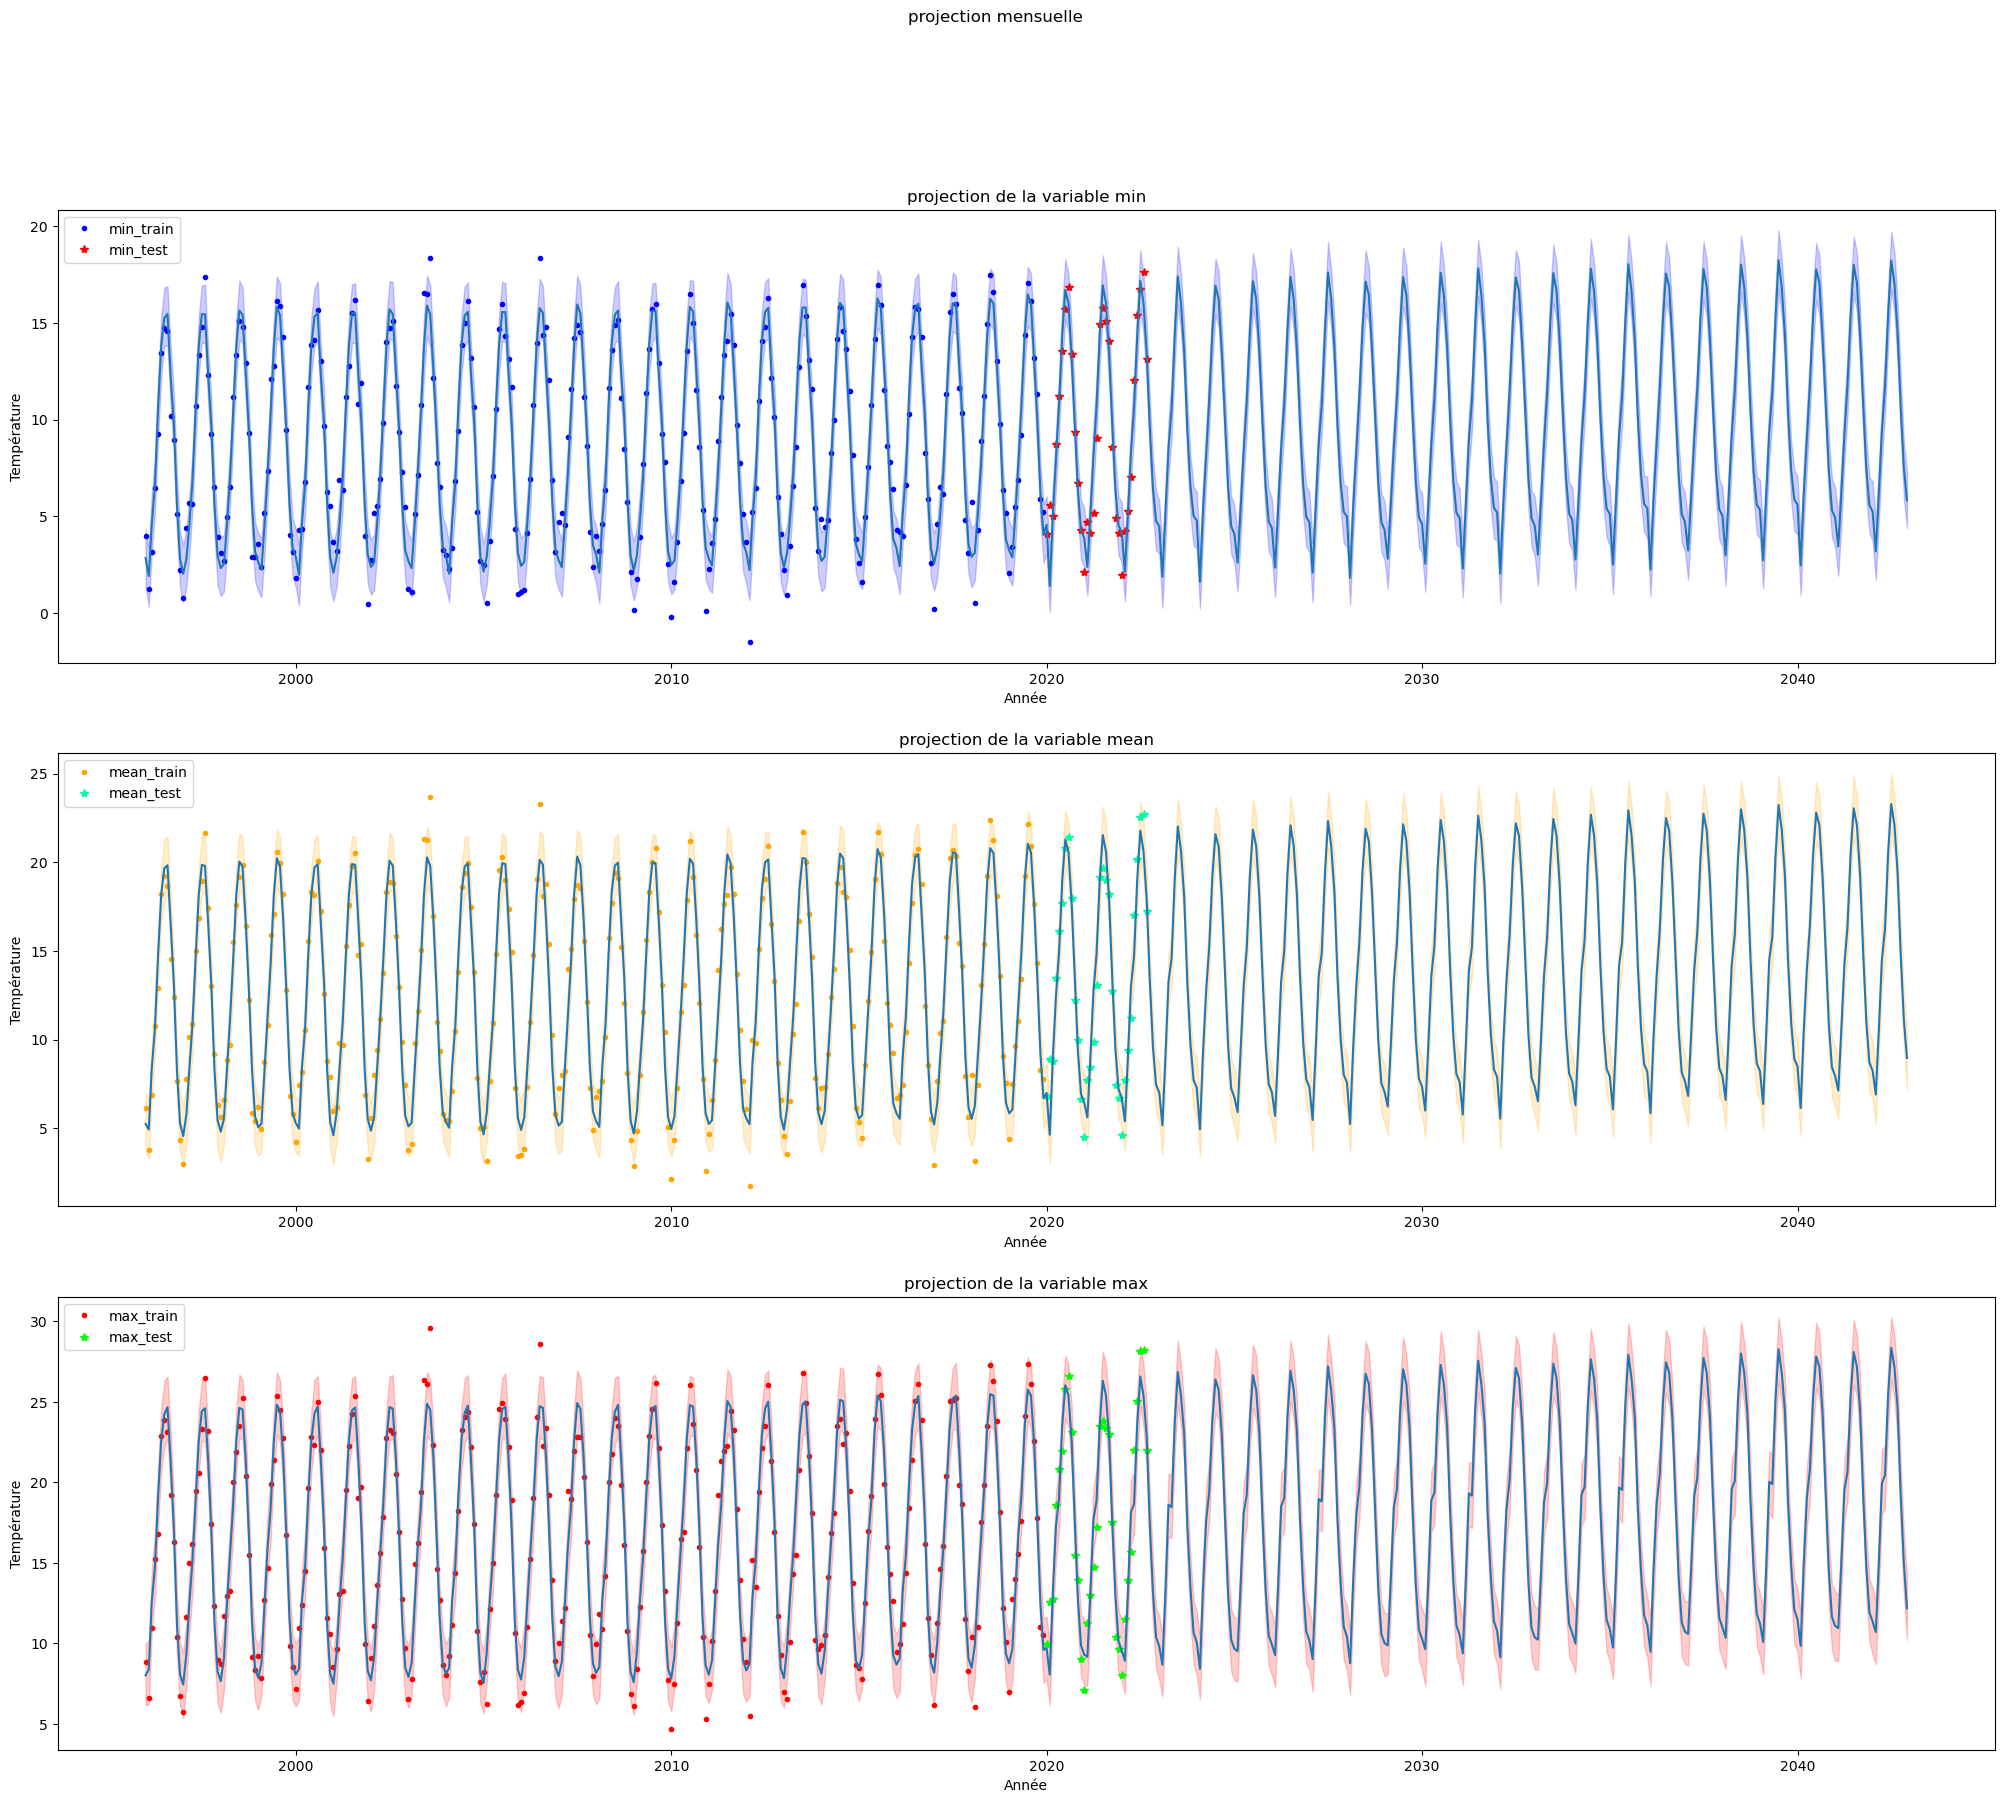

In [12]:
# paramètre
df = month_temp_data.groupby("date")[["min", "mean", "max"]].mean().reset_index()
nb_annee_predict = 23
graph_var = {"min": 0, "mean": 1, "max": 2}
colors_temp= {"min": "blue", "mean": "orange", "max": "red"}

# préparation du graphique
annee= 12
fig, axs= plt.subplots(3,1, figsize=(25,20))
periods= nb_annee_predict*annee
subplot= axs.flatten()

for var_temp in ["min", "mean", "max"]:
    graph_forecast_period(df, var_temp, colors_temp[var_temp], periods, subplot[graph_var[var_temp]], 'm')  

fig.suptitle("projection mensuelle")
plt.show()

### <a name='temp_an_day'>4.3 Projection journalière</a> <a href='#temp_an'>↑Haut</a>

13:26:13 - cmdstanpy - INFO - Chain [1] start processing
13:26:13 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:18 - cmdstanpy - INFO - Chain [1] done processing
13:26:22 - cmdstanpy - INFO - Chain [1] start processing
13:26:22 - cmdstanpy - INFO - Chain [1] done processing


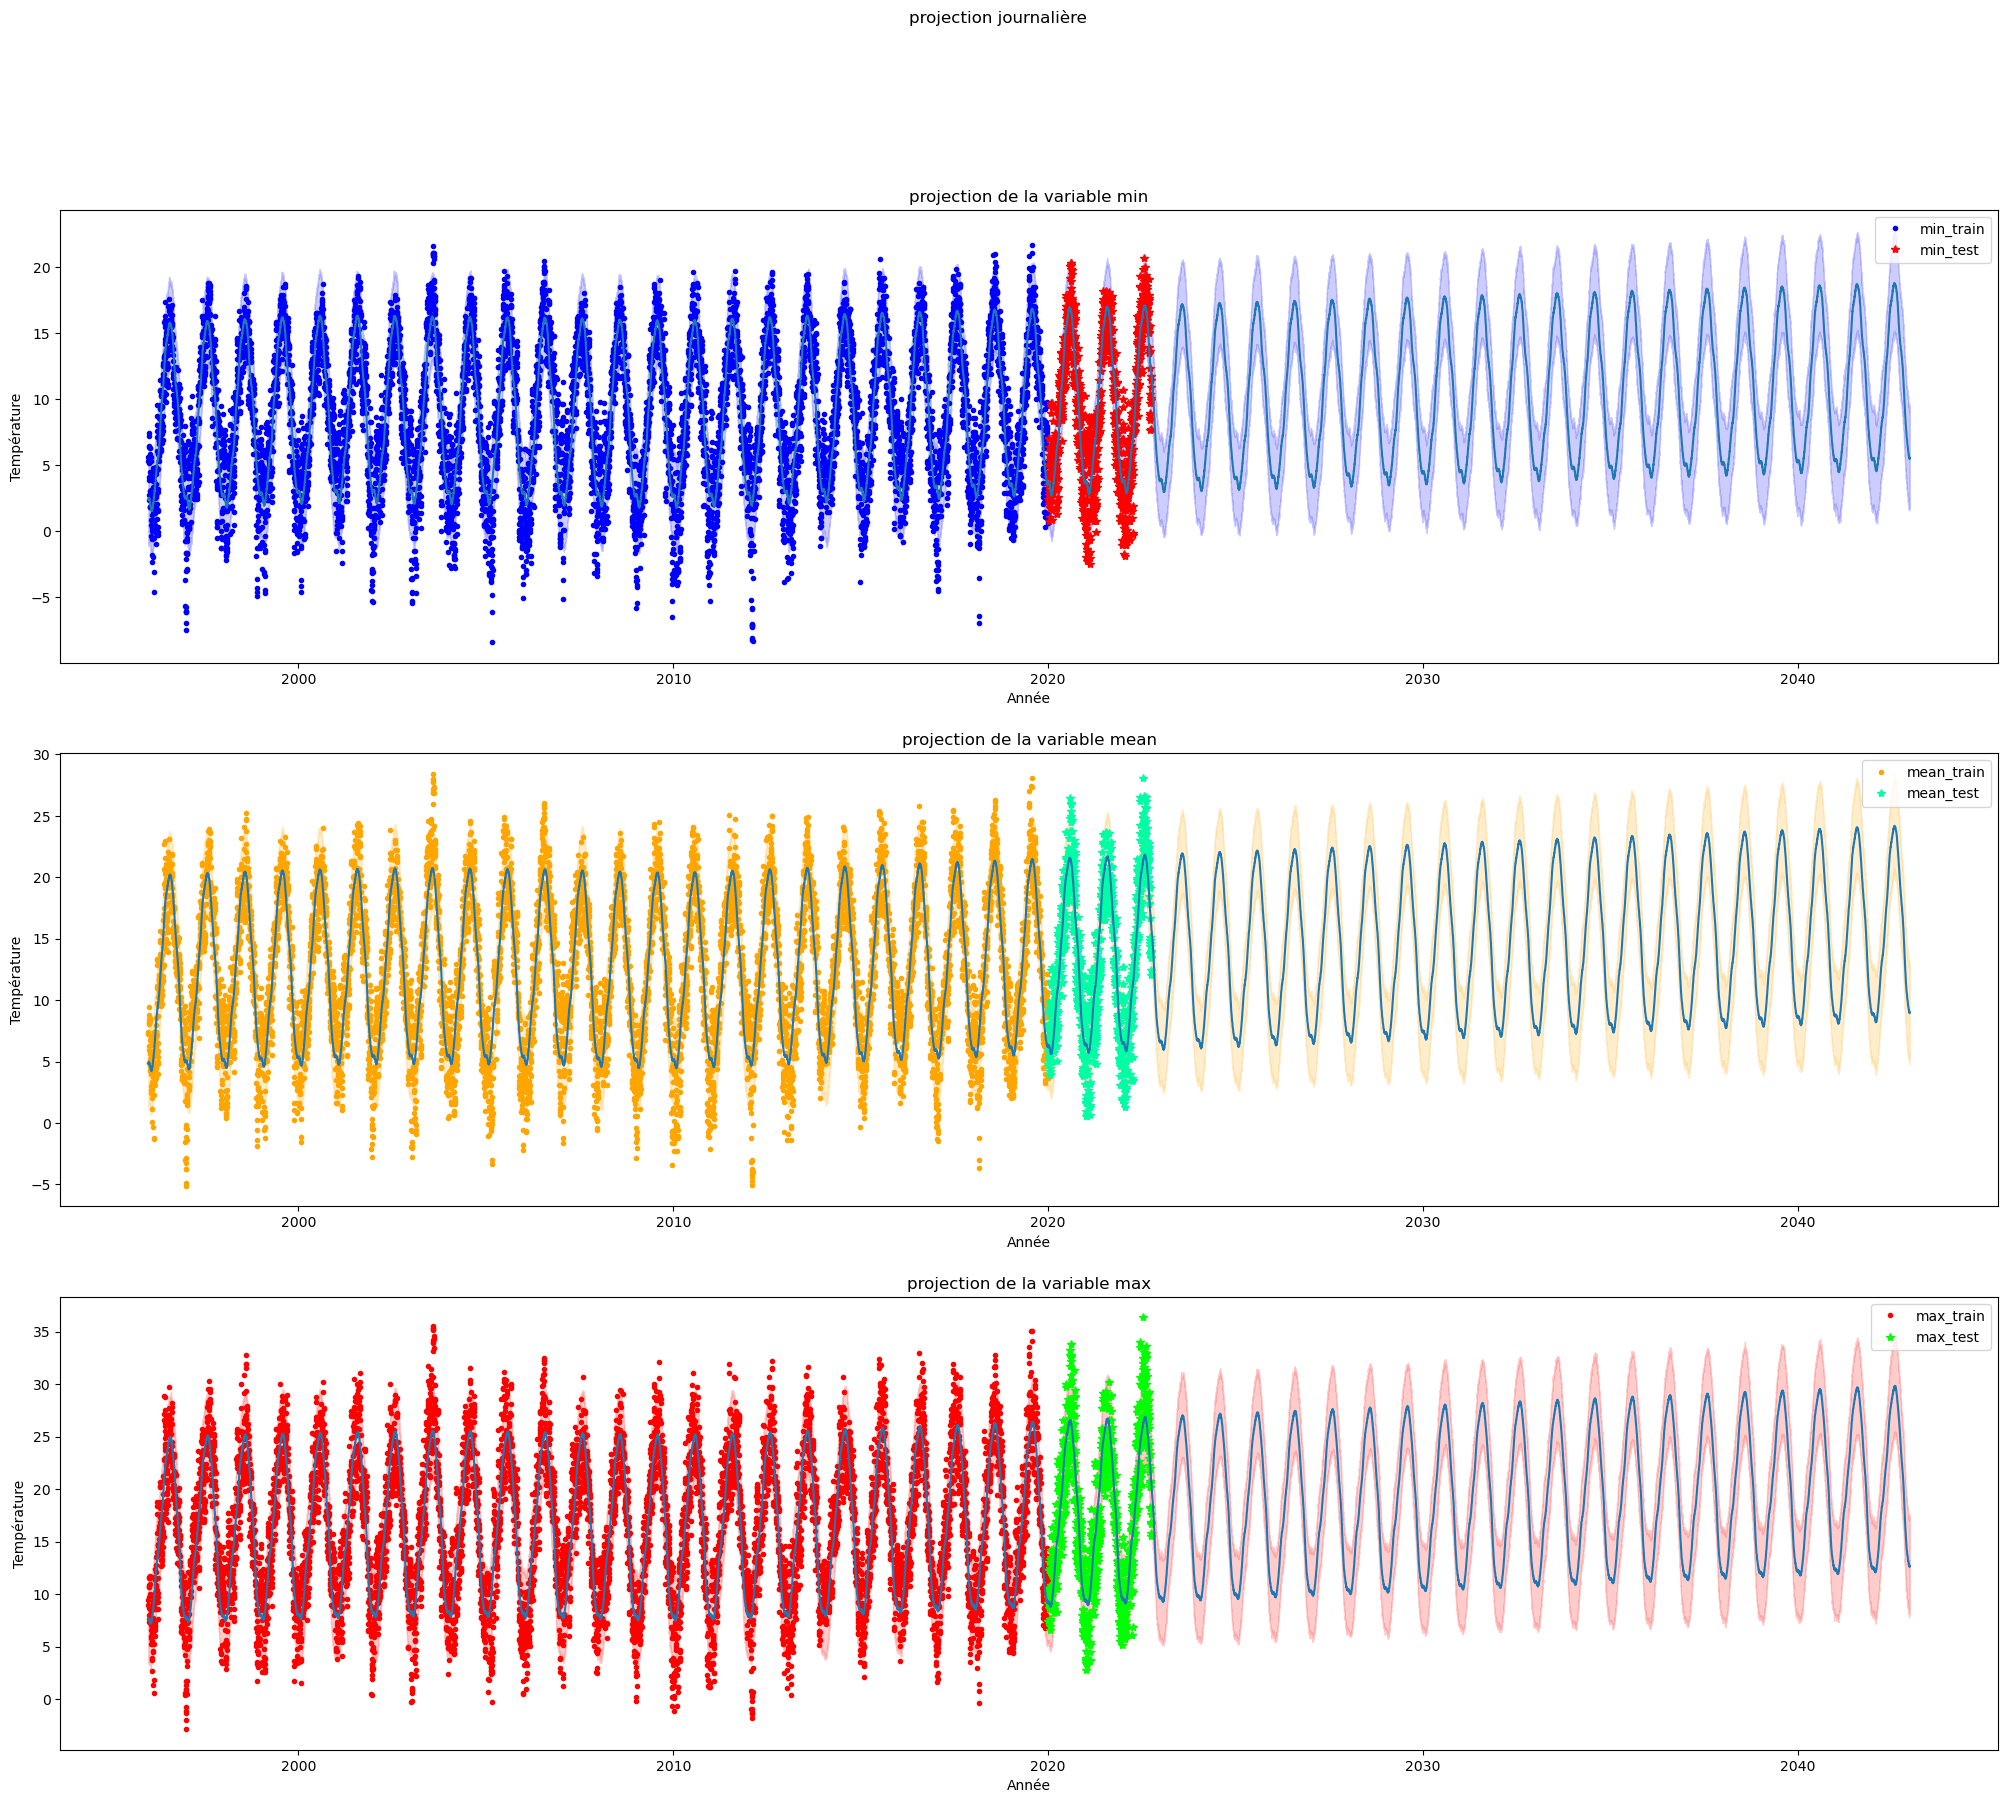

In [13]:
# paramètre
df = day_temp_data.groupby("date")[["min", "mean", "max"]].mean().reset_index()
nb_annee_predict = 23
graph_var = {"min": 0, "mean": 1, "max": 2}
colors_temp= {"min": "blue", "mean": "orange", "max": "red"}

# préparation du graphique
annee= 365
fig, axs= plt.subplots(3,1, figsize=(25,20))
periods= nb_annee_predict*annee
subplot= axs.flatten()

models= {}
for var_temp in ["min", "mean", "max"]:
    model= graph_forecast_period(df, var_temp, colors_temp[var_temp], periods, subplot[graph_var[var_temp]], "d")
    models[var_temp]= model

fig.suptitle("projection journalière")
plt.show()

### <a name='temp_an_MSE'>4.4 MSE et RMSE</a> <a href='#temp_an'>↑Haut</a>

In [14]:
daily_cross_df= cross_validation(models["mean"], initial = '730 days', period = '180 days', horizon = '365 days', parallel= "processes")
daily_cross_df.head(5)

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 1998-04-21  11.165550    7.903803   14.455418  12.610385 1998-04-20
1 1998-04-22  11.315407    8.153939   14.569154  14.349339 1998-04-20
2 1998-04-23  11.565255    8.397782   14.700497  13.693178 1998-04-20
3 1998-04-24  11.918772    8.606074   15.124113  13.453539 1998-04-20
4 1998-04-25  12.039548    8.781133   15.165797  14.111064 1998-04-20

In [15]:
daily_perf_df= performance_metrics(daily_cross_df)
daily_perf_df.head(5)

horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  6.746796  2.597460  2.056938  0.404828  0.143058  0.230797   
1 38 days  6.685078  2.585552  2.048602  0.415407  0.141879  0.229616   
2 39 days  6.627512  2.574396  2.040881  0.414464  0.141231  0.228249   
3 40 days  6.597868  2.568631  2.040217  0.424004  0.141006  0.227371   
4 41 days  6.577171  2.564600  2.045255  0.426006  0.142274  0.227163   

   coverage  
0  0.813642  
1  0.815214  
2  0.814576  
3  0.815170  
4  0.815170

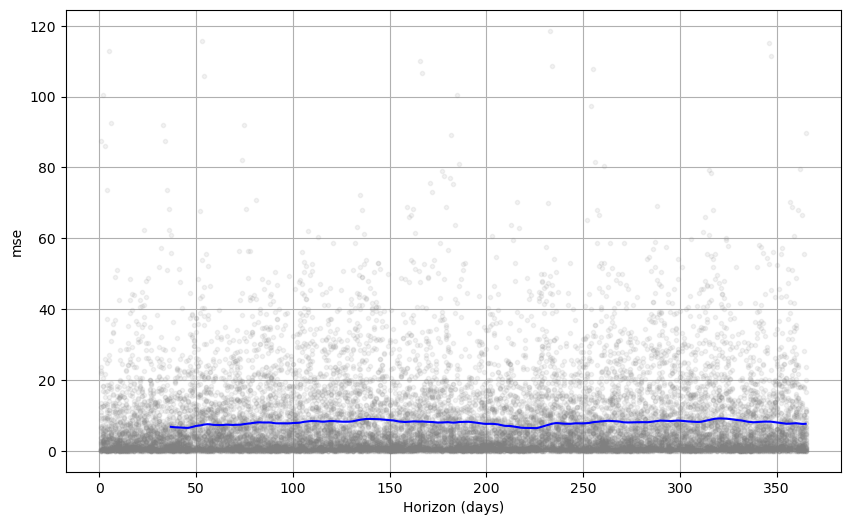

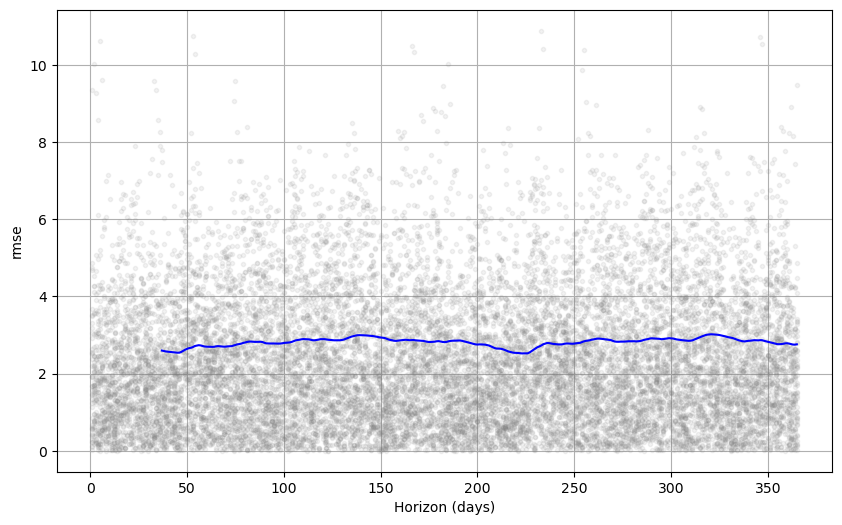

In [16]:
fig= plot_cross_validation_metric(daily_cross_df, metric="mse")
fig= plot_cross_validation_metric(daily_cross_df, metric="rmse")

## <a name='temp_an_occ'>5. Occurence de chaleur et de froid</a> <a href='#temp_an'>↑Haut</a>

### <a name='temp_an_occ_df'>5.1 Création des dataframes</a> <a href='#temp_an'>↑Haut</a>

In [17]:
occurence_city= (day_temp_data.loc[~(day_temp_data.date.dt.year == 2023)]
                 .groupby(by=["id_sta", "climat", "name", pd.Grouper(key="date", freq="Y")])
                 .agg(tx_20= ("max",lambda x: x[x>=20].count()),
                      tx_25= ("max",lambda x: x[x>=25].count()),
                      tx_30= ("max",lambda x: x[x>=30].count()),
                      tn_20= ("min",lambda x: x[x>=20].count()),
                      tn_n10= ("min",lambda x: x[x<=-10].count()),
                      tn_n5= ("min",lambda x: x[x<=-5].count()),
                      tn_0= ("min",lambda x: x[x<=0].count()),
                      tx_0= ("max",lambda x: x[x<=0].count()))
                 .reset_index())
#occurence_city["date"]= occurence_city["date"].dt.year
occurence_city.head(5)

id_sta        climat       name       date  tx_20  tx_25  tx_30  tn_20  \
0    7005  océanique NO  Abbeville 1996-12-31     54     16      1      0   
1    7005  océanique NO  Abbeville 1997-12-31     79     21      2      0   
2    7005  océanique NO  Abbeville 1998-12-31     52     14      1      0   
3    7005  océanique NO  Abbeville 1999-12-31     76     27      3      1   
4    7005  océanique NO  Abbeville 2000-12-31     64     11      1      0   

   tn_n10  tn_n5  tn_0  tx_0  
0       2     11    61    14  
1       3      8    36     9  
2       0      4    31     5  
3       0      0    24     1  
4       0      0    21     1

In [18]:
occurence_city= occurence_city.loc[~(occurence_city.tx_20 == 0)]

In [19]:
occurence_climat = (occurence_city
                    .groupby(by=["climat", "date"])
                    [["tx_20","tx_25","tx_30","tn_20", "tn_n10", "tn_n5", "tn_0", "tx_0"]]
                    .mean()
                    .reset_index())
occurence_climat.head(5)

climat       date   tx_20  tx_25  tx_30  tn_20  tn_n10  tn_n5   tn_0  \
0  montagne 1996-12-31   90.75  33.25   0.75   0.00    2.50  15.00  64.25   
1  montagne 1997-12-31  124.75  54.00   4.25   0.50    0.75   8.75  59.00   
2  montagne 1998-12-31  107.25  47.50  12.75   0.50    2.00  17.00  73.75   
3  montagne 1999-12-31  119.25  46.25   4.00   0.50    2.75  20.75  76.25   
4  montagne 2000-12-31  110.50  47.00   6.00   0.25    0.75   9.25  63.75   

    tx_0  
0   7.50  
1   4.25  
2   5.00  
3  11.25  
4   3.75

In [20]:
occurence_national = (occurence_city
                    .groupby(by=["date"])
                    [["tx_20","tx_25","tx_30","tn_20", "tn_n10", "tn_n5", "tn_0", "tx_0"]]
                    .mean()
                    .reset_index())
occurence_national.head(5)

date       tx_20      tx_25      tx_30     tn_20    tn_n10     tn_n5  \
0 1996-12-31   96.589744  39.846154   5.923077  4.615385  1.179487  7.282051   
1 1997-12-31  126.153846  53.846154   8.435897  7.641026  1.128205  5.205128   
2 1998-12-31  107.076923  43.435897  11.282051  7.974359  0.435897  6.410256   
3 1999-12-31  118.230769  51.897436   7.769231  7.717949  0.435897  4.615385   
4 2000-12-31  110.897436  45.820513   8.128205  5.538462  0.205128  2.641026   

        tn_0      tx_0  
0  40.871795  7.641026  
1  32.897436  6.051282  
2  38.153846  4.025641  
3  30.794872  3.230769  
4  23.820513  1.333333

### <a name='temp_an_chaud'>5.2 Occurence de chaleur</a> <a href='#temp_an'>↑Haut</a>

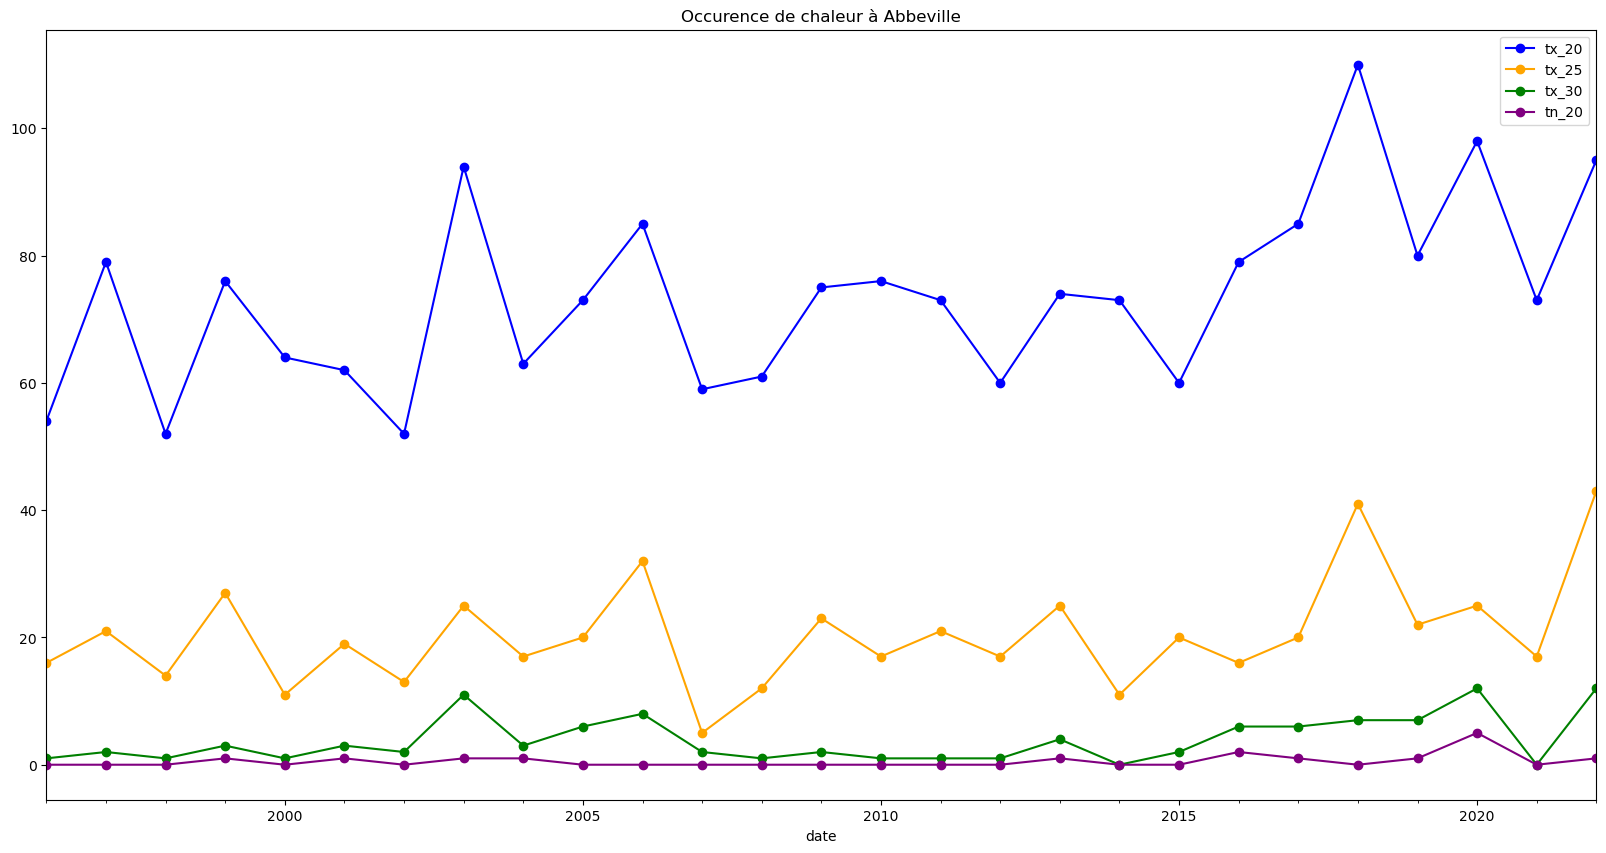

In [21]:
fig= plt.Figure(figsize=(20,10))

graph_occurence_chaleur(occurence_city.loc[(occurence_city.name== "Abbeville")], "Occurence de chaleur à Abbeville")

#### <a name='temp_an_chaud_clim'>5.2.1 Par climat</a> <a href='#temp_an'>↑Haut</a>

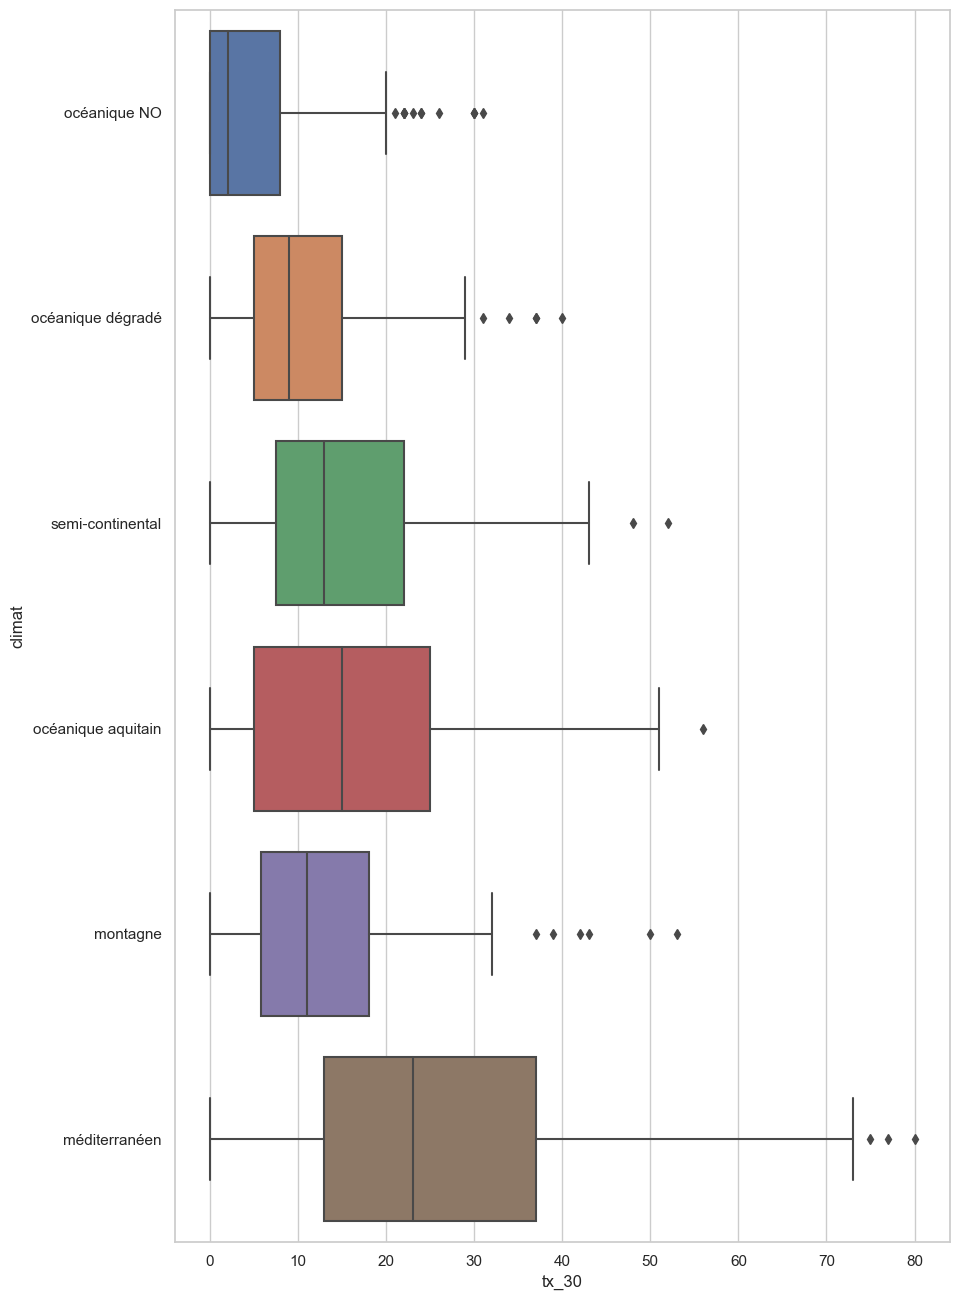

In [22]:
sns.set_theme(style="whitegrid")
fig= plt.figure(figsize=(10,16))
sns.boxplot(x=occurence_city.tx_30, y=occurence_city.climat, orient='h')
plt.show()

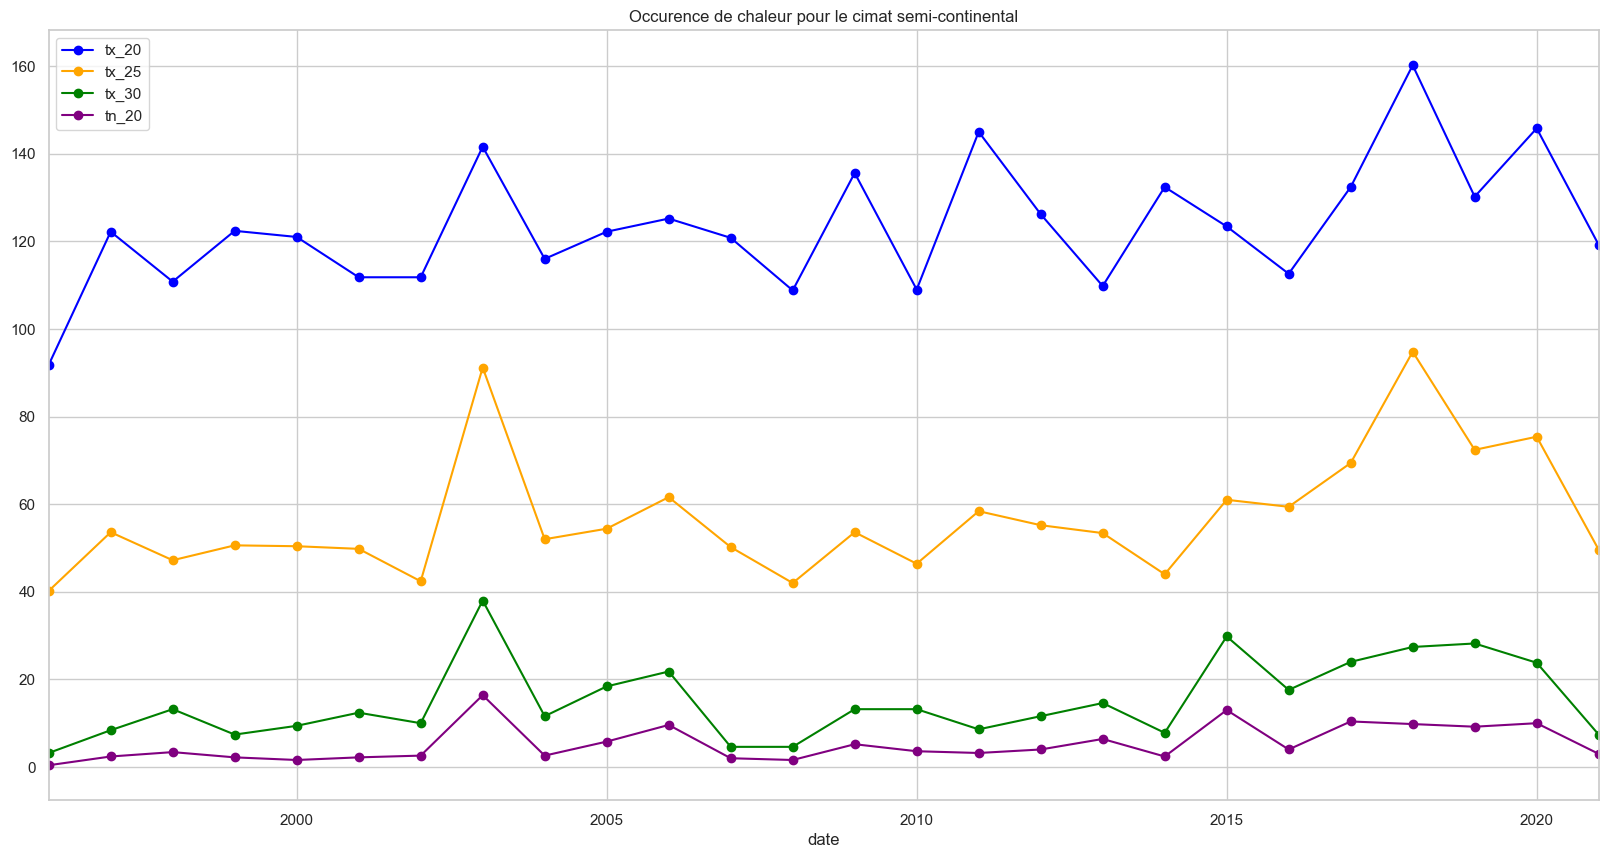

In [23]:
graph_occurence_chaleur(occurence_climat.loc[(occurence_climat.climat == "semi-continental")& (occurence_climat.date.dt.year < 2022)], 
                      "Occurence de chaleur pour le cimat semi-continental")

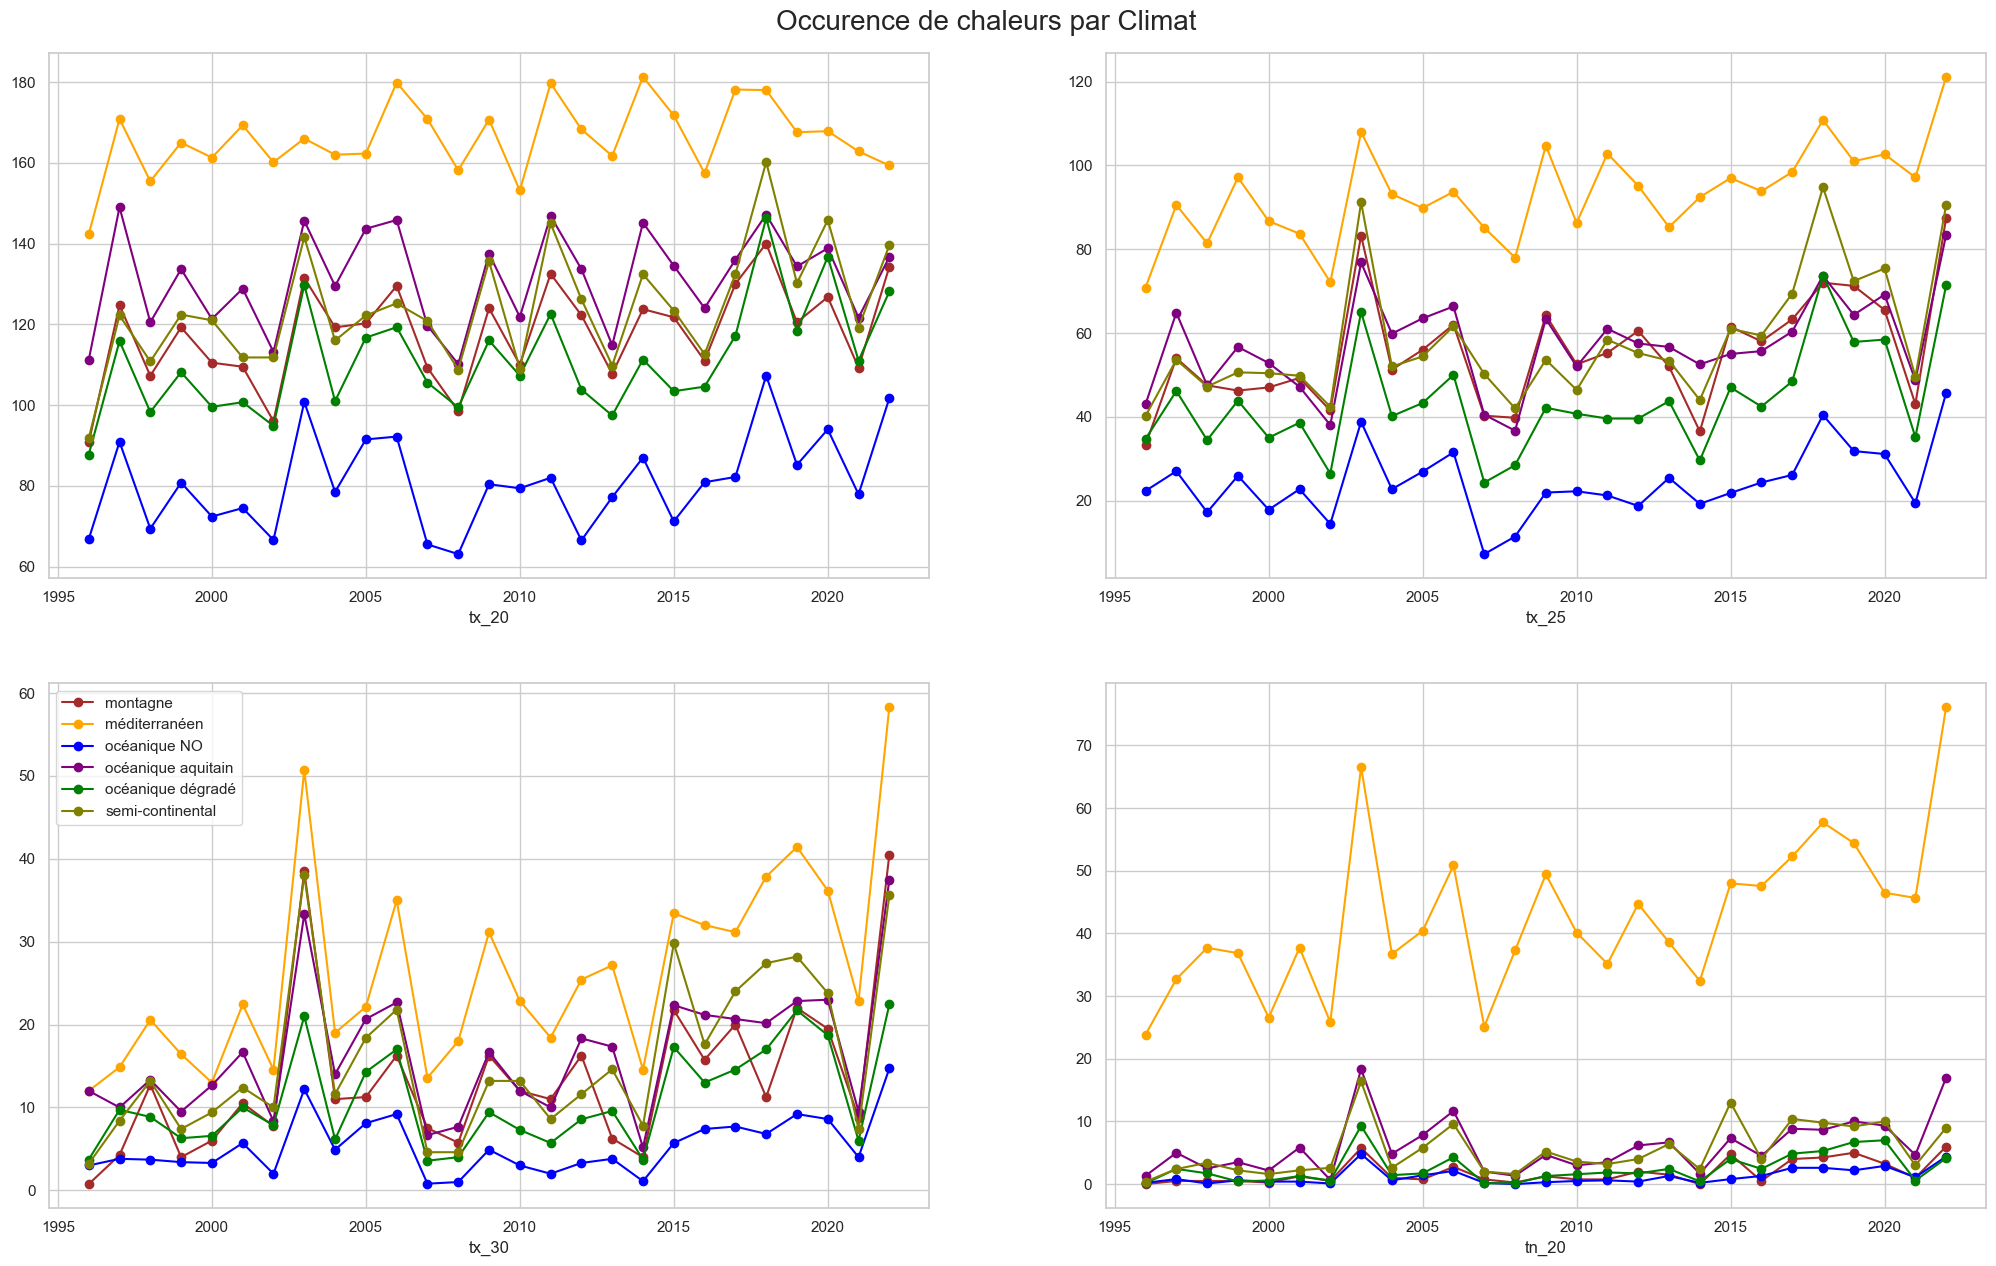

In [24]:
fig, axs= plt.subplots(2, 2, figsize=(25,15))
subplt = axs.flatten()
graph_var = {"tx_20": 0, "tx_25": 1, "tx_30": 2, "tn_20": 3}

for var_temp in ["tx_20", "tx_25", "tx_30", "tn_20"]:
    for climat in occurence_climat.climat.unique():
        subplt[graph_var[var_temp]].plot(occurence_climat.loc[occurence_climat.climat == climat]["date"].dt.year, 
                                        occurence_climat.loc[occurence_climat.climat == climat][var_temp], '-o',
                                        c=climat_color[climat], label=climat)
    subplt[graph_var[var_temp]].set_xlabel(var_temp)
    
        
subplt[2].legend()
plt.suptitle("Occurence de chaleurs par Climat", fontsize=20, va='center', y=0.9, x=0.5)
plt.show()

#### <a name='temp_an_chaud_nat'>5.2.2 National</a> <a href='#temp_an'>↑Haut</a>

13:26:58 - cmdstanpy - INFO - Chain [1] start processing
13:26:58 - cmdstanpy - INFO - Chain [1] done processing
13:26:58 - cmdstanpy - INFO - Chain [1] start processing
13:26:58 - cmdstanpy - INFO - Chain [1] done processing
13:26:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:59 - cmdstanpy - INFO - Chain [1] done processing
13:26:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:59 - cmdstanpy - INFO - Chain [1] done processing


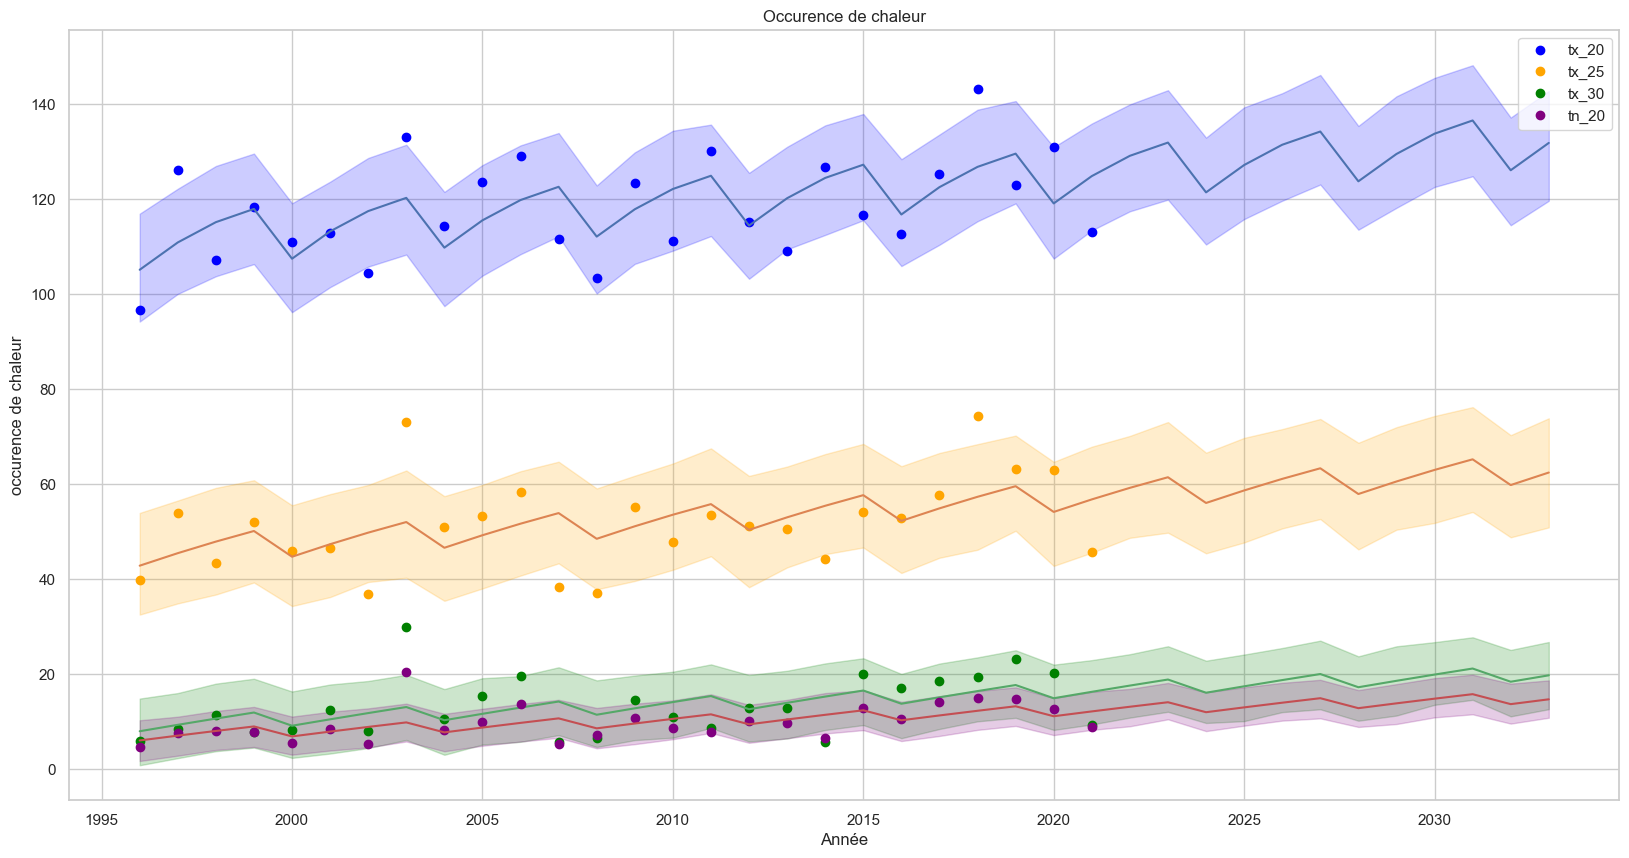

In [25]:
df= occurence_national.loc[occurence_national["date"].dt.year < 2022 ]

fig, ax= plt.subplots(figsize=(20,10))

graph_forecast(df, "tx_20", "blue", 15)
graph_forecast(df, "tx_25", "orange", 15)
graph_forecast(df, "tx_30", "green", 15)
graph_forecast(df, "tn_20", "purple", 15)

plt.title("Occurence de chaleur")
plt.legend()
plt.ylabel("occurence de chaleur")
plt.xlabel("Année")
plt.show()

### <a name='temp_an_froid'>5.3 Occurence de froid</a> <a href='#temp_an'>↑Haut</a>

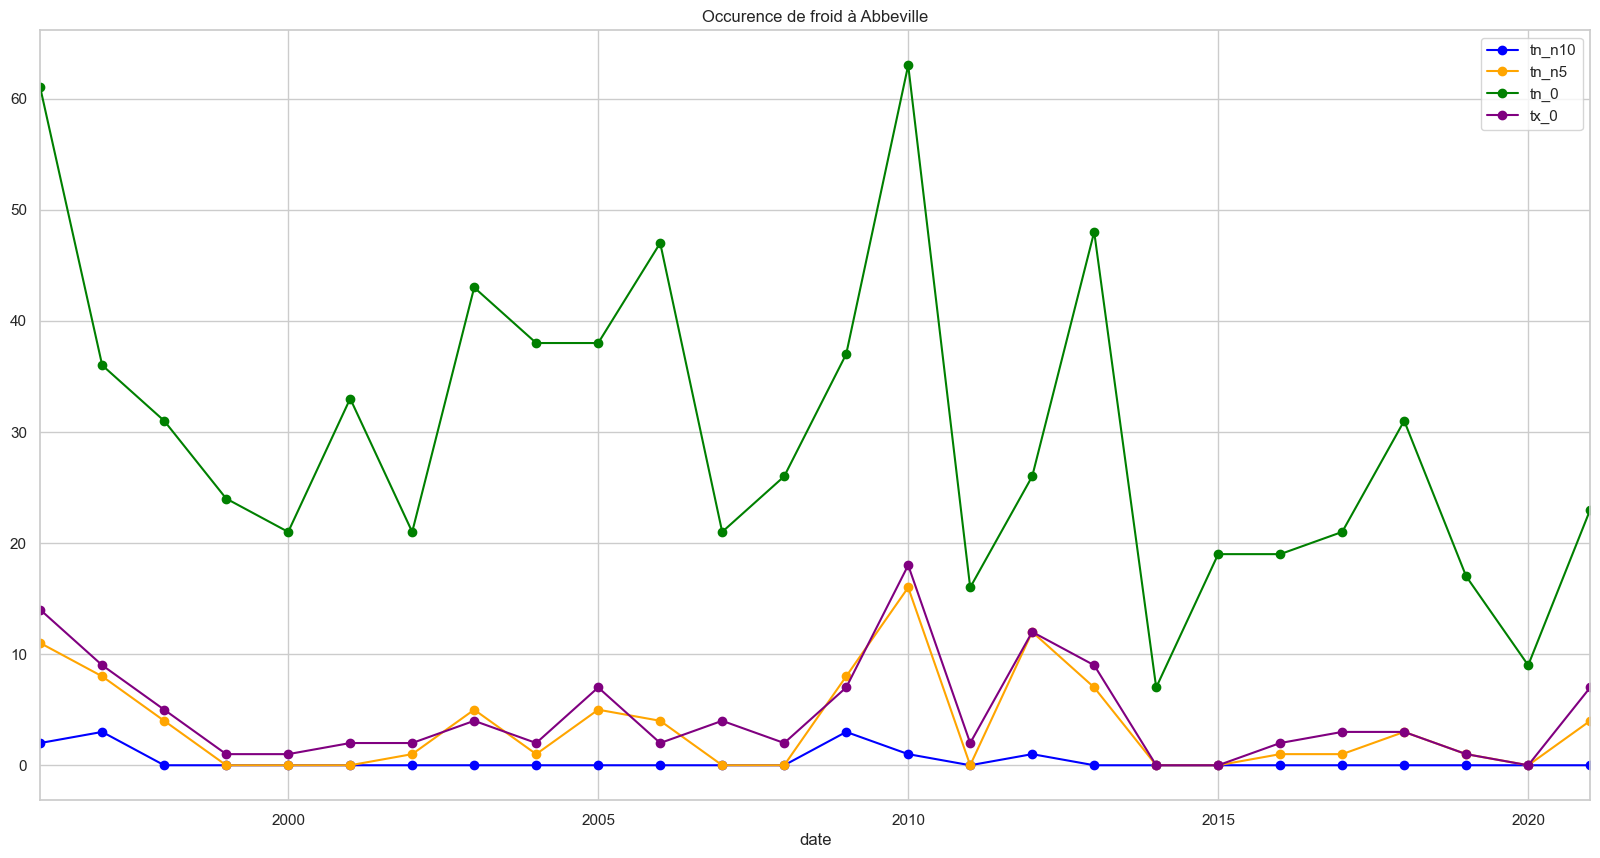

In [26]:
fig= plt.Figure(figsize=(20,10))

graph_occurence_froid(occurence_city.loc[(occurence_city.name== "Abbeville")& (occurence_city.date.dt.year < 2022)], "Occurence de froid à Abbeville")

#### <a name='temp_an_froid_clim'>5.3.1 Par climat</a> <a href='#temp_an'>↑Haut</a>

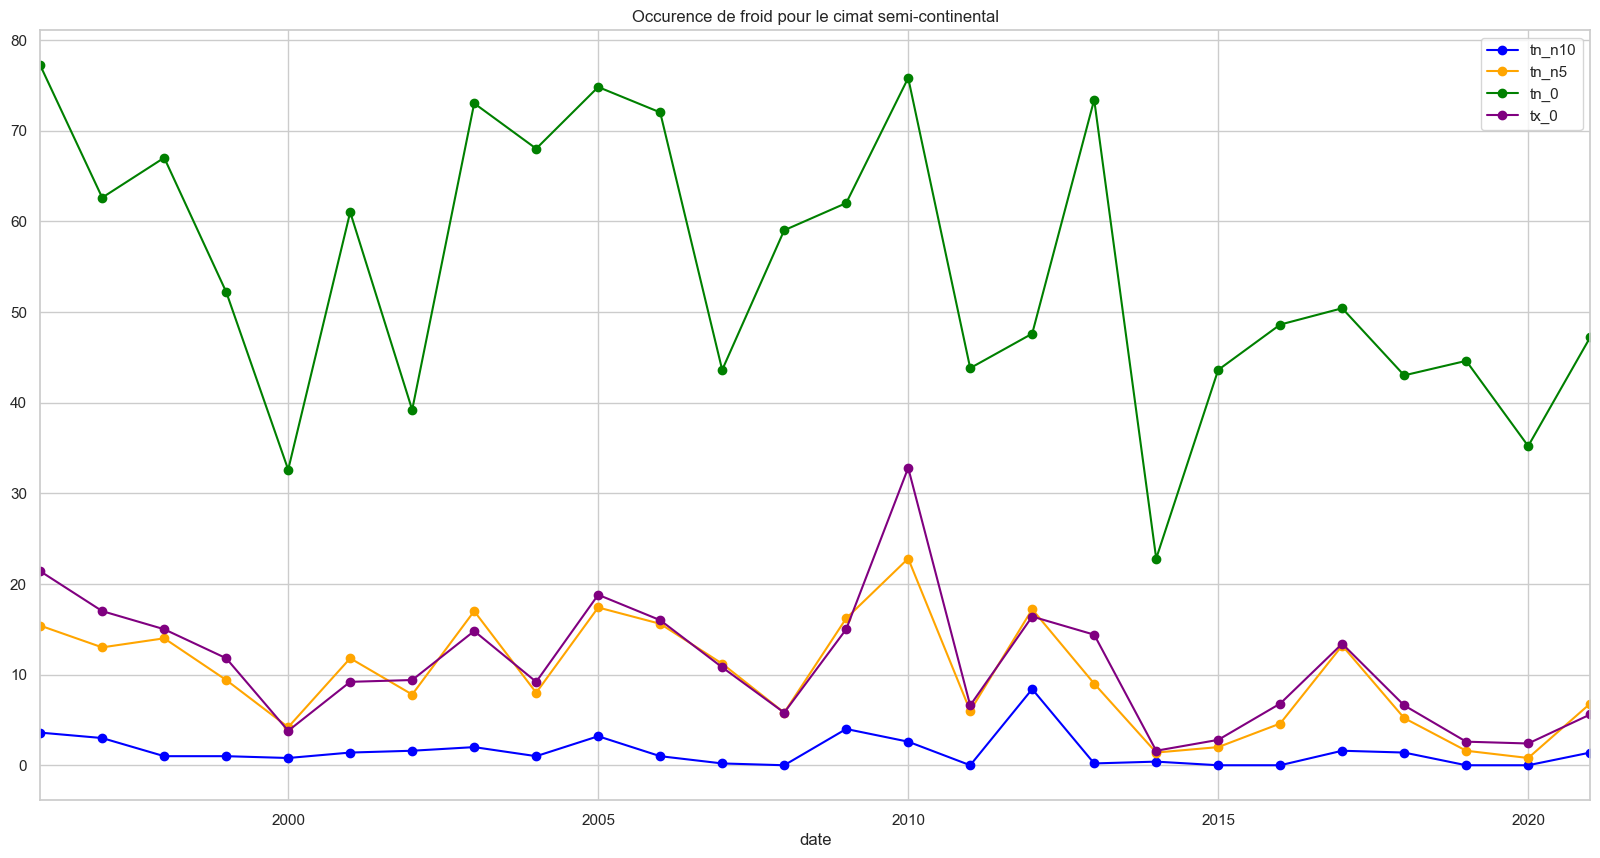

In [27]:
graph_occurence_froid(occurence_climat.loc[(occurence_climat.climat == "semi-continental")& (occurence_climat.date.dt.year < 2022)], 
                      "Occurence de froid pour le cimat semi-continental")

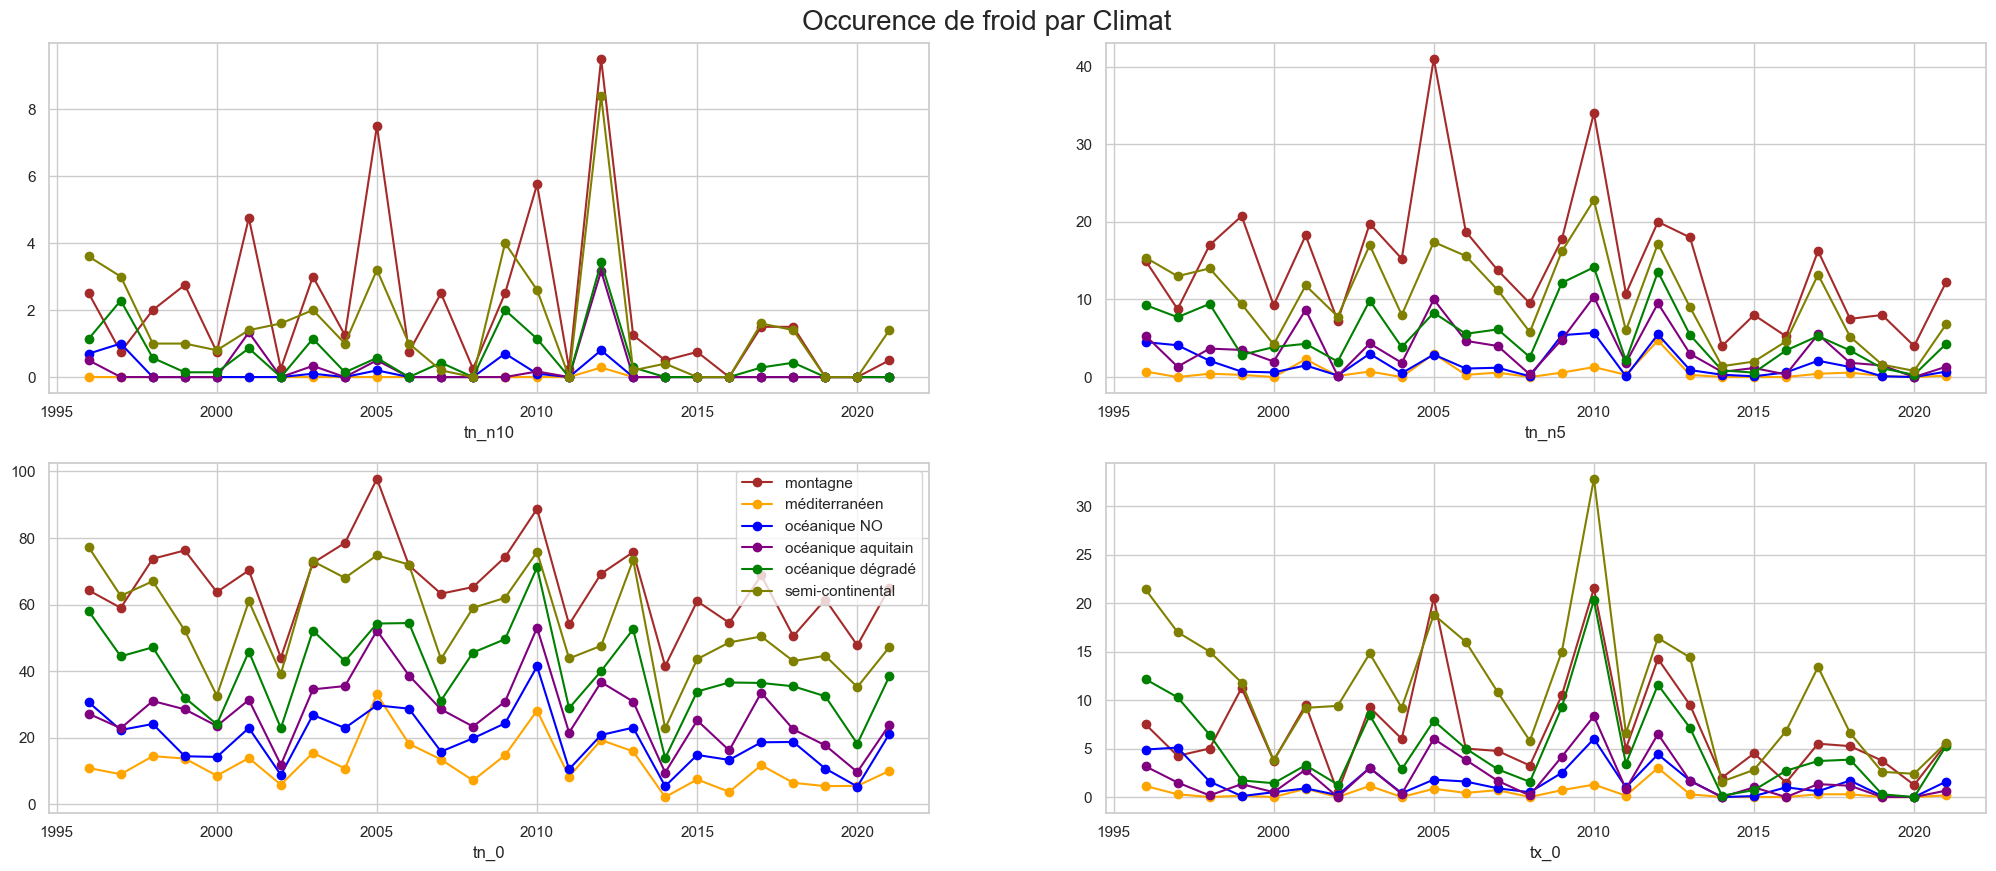

In [28]:
fig, axs= plt.subplots(2, 2, figsize=(25,10))
subplt = axs.flatten()
graph_var = {"tn_n10": 0, "tn_n5": 1, "tn_0": 2, "tx_0": 3}
df= occurence_climat.loc[occurence_climat.date.dt.year < 2022]
for var_temp in ["tn_n10", "tn_n5", "tn_0", "tx_0"]:
    for climat in occurence_climat.climat.unique():
        subplt[graph_var[var_temp]].plot(df.loc[df.climat == climat]["date"].dt.year, 
                                        df.loc[df.climat == climat][var_temp], '-o',
                                        c=climat_color[climat], label=climat)
    subplt[graph_var[var_temp]].set_xlabel(var_temp)
        
subplt[2].legend()
plt.suptitle("Occurence de froid par Climat", fontsize=20, va='center', y=0.9, x=0.5)
plt.show()

#### <a name='temp_an_froid_nat'>5.3.2 National</a> <a href='#temp_an'>↑Haut</a>

13:27:00 - cmdstanpy - INFO - Chain [1] start processing
13:27:00 - cmdstanpy - INFO - Chain [1] done processing
13:27:01 - cmdstanpy - INFO - Chain [1] start processing
13:27:01 - cmdstanpy - INFO - Chain [1] done processing
13:27:01 - cmdstanpy - INFO - Chain [1] start processing
13:27:01 - cmdstanpy - INFO - Chain [1] done processing
13:27:01 - cmdstanpy - INFO - Chain [1] start processing
13:27:01 - cmdstanpy - INFO - Chain [1] done processing


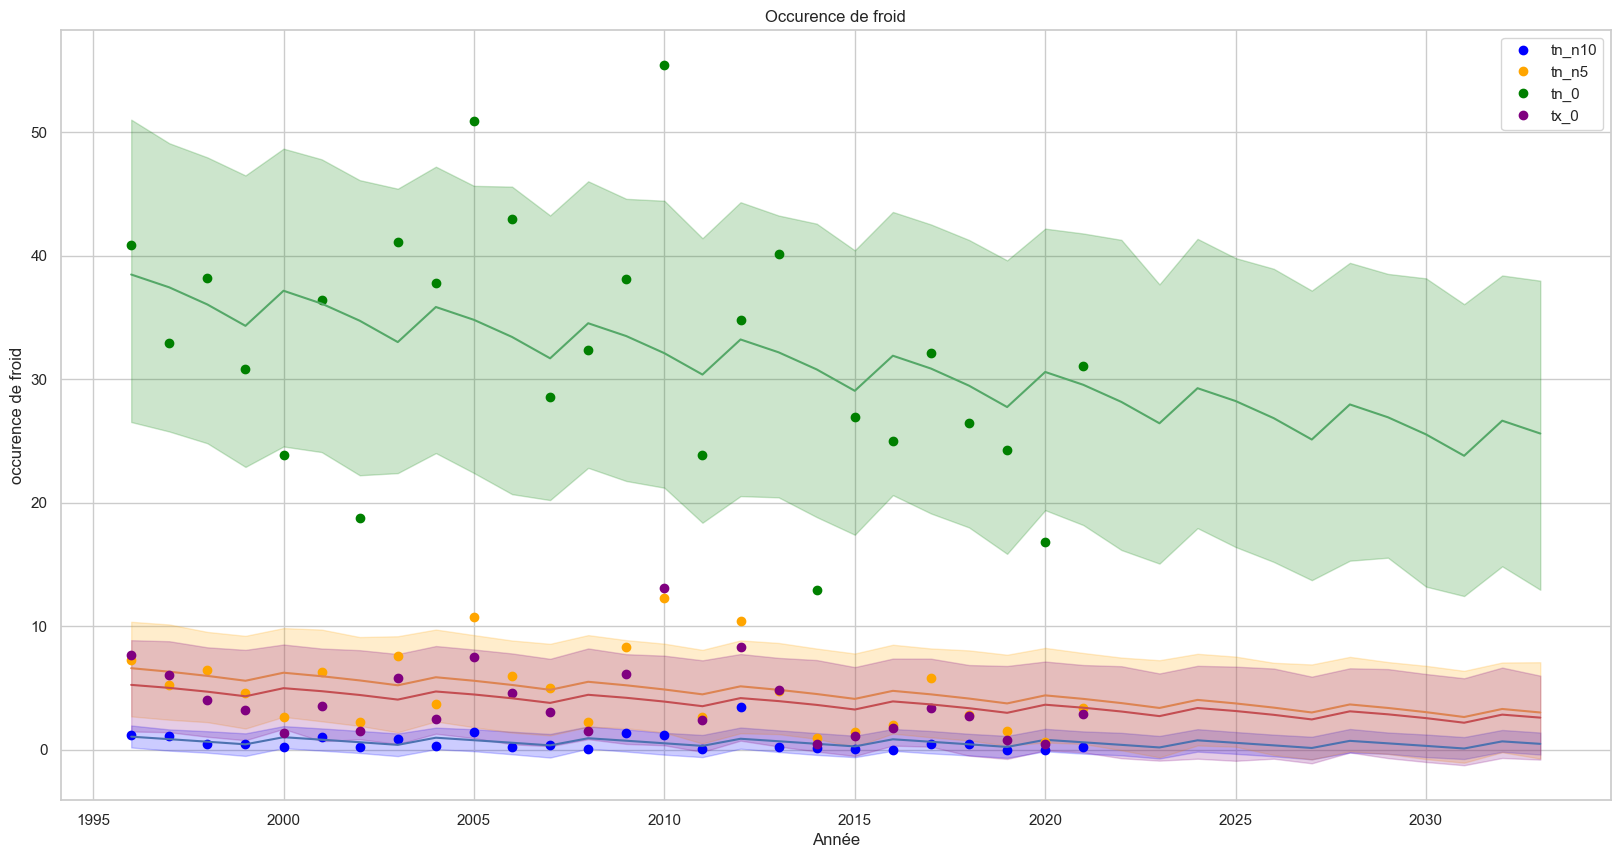

In [29]:
df= occurence_national.loc[occurence_national["date"].dt.year < 2022 ]

fig, ax= plt.subplots(figsize=(20,10))

graph_forecast(df, "tn_n10", "blue", 15)
graph_forecast(df, "tn_n5", "orange", 15)
graph_forecast(df, "tn_0", "green", 15)
graph_forecast(df, "tx_0", "purple", 15)

plt.title("Occurence de froid")
plt.legend()
plt.ylabel("occurence de froid")
plt.xlabel("Année")
plt.show()

## <a name='temp_an_polar'>6. Graphique polaire</a> <a href='#temp_an'>↑Haut</a>

In [30]:
national_day_temp= (day_temp_data
                    .groupby(by=[pd.Grouper(key="date", freq="D")])
                    .agg(min= ('min', np.mean),
                         mean= ("mean", np.mean),
                         max= ("max", np.mean)
                        )
                   ).reset_index()

In [31]:
national_day_temp["mean"].min(), national_day_temp["mean"].max() 

(-5.096230158730136, 28.40993589743592)

In [32]:
start_date = "1996-01-01"
end_date = "1996-10-01"
var= "mean"
correction_minimal = -5 -10
df= national_day_temp
df= df.loc[(df.date < end_date) & (df.date >= start_date)]

daterange = df.date
dayoftheyear = pd.DatetimeIndex(
    np.array(daterange, dtype="datetime64[D]") + 3
).dayofyear  # middle of the week

activeyear = pd.DatetimeIndex(
    np.array(daterange, dtype="datetime64[D]") + 3
).year  # extract year
# Init final arrays

plt.rcParams["xtick.major.pad"] = "17"
plt.rcParams["axes.axisbelow"] = False
matplotlib.rc("axes", edgecolor="w")


big_angle = 360 / 12  # How we split our polar space

date_angle = (
    ((360 / 365) * dayoftheyear) * np.pi / 180
)  # For a day, a corresponding angle

# inner and outer ring limit values

df[var] = df[var] - correction_minimal
inner = 10 # -5¨C
outer = 50 # 35°C 

cmap = plt.get_cmap("RdYlBu_r")
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(daterange))

C:\Users\ramms\AppData\Local\Temp\ipykernel_1820\3022121060.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var] = df[var] - correction_minimal


In [33]:

def dress_axes(ax):
    ax.set_facecolor("w")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    # Here is how we position the months labels

    middles = np.arange(big_angle / 2, 360, big_angle) * np.pi / 180
    ax.set_xticks(middles)
    ax.set_xticklabels(
        [
            "Janvier",
            "Février",
            "Mars",
            "Avril",
            "mai",
            "Juin",
            "Juillet",
            "Aout",
            "Septembre",
            "Octobre",
            "Novembre",
            "Décembre",
        ]
    )
    
    ax.set_yticks([15, 25, 35, 45])
    ax.set_yticklabels(["0°C", "10°C", "20°C", "30°C"])
    # Changing radial ticks angle

    ax.set_rlabel_position(359)
    ax.tick_params(axis="both", color="w")
    plt.grid(None, axis="x")
    plt.grid(axis="y", color="w", linestyle=":", linewidth=1)
 
    # Here is the bar plot that we use as background
    bars = ax.bar(
        middles,
        outer,
        width=big_angle * np.pi / 180,
        bottom=inner,
        color="lightgray",
        edgecolor="w",
        zorder=0,
    )
    plt.ylim([2, outer])
    # Main title for the figure
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar= plt.colorbar(sm, ticks=[0,len(daterange)])
    cbar.ax.set_yticklabels([1996,2022])
    
    plt.title(
        "Evolution de la température moyenne annuelle",
        fontsize=16,
        horizontalalignment="center",
    )

In [34]:
df[var].min(), df[var].max()

(13.672686202686227, 38.099371794871814)

In [35]:
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, polar=True)
dress_axes(ax)
# ne pas afficher le graphique
plt.close()

def update(i):
    color= cmap(norm(i))
    if i > 1:
        ax.plot(date_angle[i-2:i], df.iloc[i-2:i][var], "-", linewidth=2, 
                c=color)
        
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=str(df.iloc[i]["date"].year),
            markerfacecolor=color,
            markersize=15,
        ),
    ]
    ax.legend(handles=legend_elements,  loc="center", fontsize=13, frameon=False)
        
    print("\rProgression: {:05.2f}%".format((i+1)/len(date_angle)*100), end="")
    return ax

anim = FuncAnimation(
    fig, update, interval=2, frames=len(daterange), repeat=False
)

C:\Users\ramms\AppData\Local\Temp\ipykernel_1820\3740888508.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar= plt.colorbar(sm, ticks=[0,len(daterange)])


In [36]:
# Génération de la vidéo directement dans jupyterlab

# HTML(anim.to_html5_video())

In [37]:
# Génération et sauvegarde de la vidéo

# f = r"./Animation/evolution_des_temperature_moyenne.mp4" 
# writervideo = FFMpegWriter(fps=60) 
# anim.save(f, writer=writervideo)

In [38]:
from IPython.display import Video

Video("Animation/evolution_des_temperature_moyenne.mp4")

[]

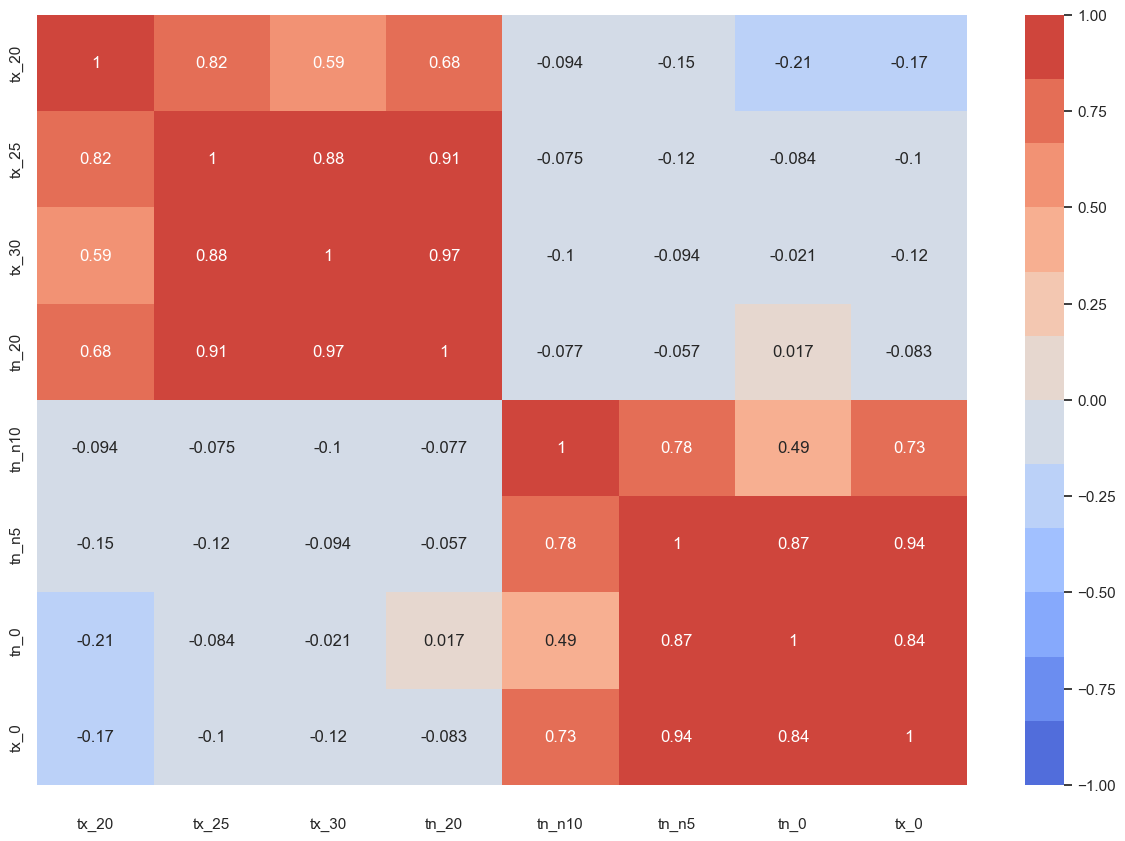

In [39]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(
    occurence_national[["tx_20","tx_25","tx_30","tn_20","tn_n10", "tn_n5", "tn_0", "tx_0"]].corr(), 
    annot=True, vmin=-1, vmax=1, cmap=sns.color_palette ("coolwarm", 12))
plt.plot()